# APX Power Spot Exchange - Exploratory Data Analysis

## Introduction
The UKPX RPD Historical data is available through the following site https://www.apxgroup.com/market-results/apx-power-uk/ukpx-rpd-historical-data/.
I will be loading some of the data and running some basic analysis to see if we can gain any useful insights into the shape of the data.

## Data
The data is available on the FTP site *ftp.apxgroup.com* with credentials *ae.rpduser* / *freedata*.

The data files used for analysis in this project are:

* rpd_rpd.csv - Half hourly RPD (reference price data) prices for each date
* rpd_spotpeak.csv - Spot Index, Inustrial Peakload Index, Extended Peakload Index
* rpd_volume.csv - Half hourly trading volumes for each date

Furthermore, these files are available for each year from 2004

## Code / Analysis
### Initialisation and downloading data

In [105]:
# Import libraries
%matplotlib inline
import ftplib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise Variables
label_dict = {12: ['Dec', 'Winter'], 1: ['Jan', 'Winter'], 2: ['Feb','Winter'],
               3: ['Mar', 'Spring'], 4: ['Apr', 'Spring'], 5: ['May', 'Spring'],
               6: ['Jun', 'Summer'], 7: ['Jul', 'Summer'], 8: ['Aug', 'Summer'],
               9: ['Sep', 'Autumn'], 10: ['Oct', 'Autumn'], 11: ['Nov', 'Autumn']}

dow_dict = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

In [2]:
# Download raw data from APX FTP site
ftp = ftplib.FTP('ftp.apxgroup.com', 'ae.rpduser', 'freedata')

file_list = ['rpd_rpd.csv', 'rpd_spotpeak.csv', 'rpd_volume.csv']
years = [x for x in range(2004, 2015)]

for file in file_list:
    if not os.path.exists(file):
        tmp_file  = open(file, 'wb')
        ftp.retrbinary('RETR ' + file, tmp_file.write)
        tmp_file.close()
        
for file in file_list:
    for year in years:
        if not os.path.exists('./' + str(year) + '_' + file):
            tmp_file  = open('./' + str(year) + '_' + file, 'wb')
            ftp.retrbinary('RETR ' + './' + str(year) + '/' + file, tmp_file.write)
            tmp_file.close()

ftp.quit()

'221 Thank you for using APX GROUP FTP Service. Questions concerning usage of this site should be directed data@apxgroup.com.'

### Half-hourly Spot Price Data
In this section we will analyse the half-hourly (HH) spot prices for 2015, to get an insight into the 'shape' of the daily prices.

In [81]:
# Read data into pandas data frame

def read_rpd_data(filename):
    df = pd.read_csv(filename,
                     skiprows=7,
                     index_col=0,
                     usecols=[x for x in range(0,49)],
                     nrows=365,
                     parse_dates=True,
                     dayfirst=True)

    # Get column headers
    cols = list(df.columns.values)
    # Remove text (i.e. 'HH -12' becomes '12')
    new_cols = [x[4:6] for x in cols]
    df.columns = new_cols
    # Sort columns so they are in order from 00:00 to 23:30
    ord_cols = sorted(new_cols)
    df = df[ord_cols]
    # Now replace column names with times (i.e. '09:30')
    hours = ['%s:%s' % (h, m) for h in (list(range(0, 24))) for m in ('00', '30')]
    df.columns = hours
    
    return df

rpd_df = read_rpd_data('rpd_rpd.csv')

#### Summary data for half-hourly spot prices over the year:

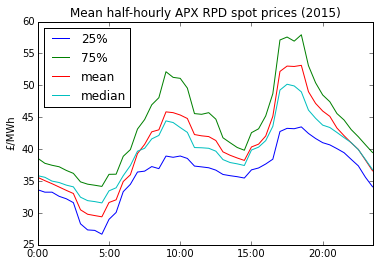

In [90]:
# Create a summary data frame containing the mean, median and quantiles 
# for each half-hour period
sum_df = pd.DataFrame({'mean': rpd_df.mean(), 
                       'median': rpd_df.median(),
                       '25%': rpd_df.quantile(0.25), 
                       '75%': rpd_df.quantile(0.75)})

sum_df.plot()
plt.ylabel('£/MWh')
plt.title('Mean half-hourly APX RPD spot prices (2015)')
plt.show()

The prices appear to follow the same general shape each day, with two local minimas at 04:30 and 14:30 each day, and two maximas at 09:30 and 18:00 each day.  This corresponds well with expected low and high energy usages.  The variation in data is larger at the maximas than the minimas.

#### Mean half-hourly spot prices per season:

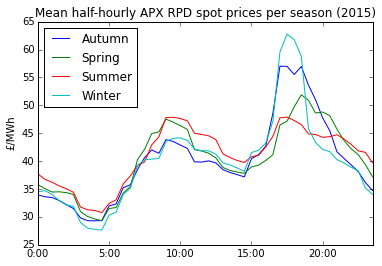

In [83]:
# Get the index values (i.e datetimes)
idx = pd.DatetimeIndex(rpd_df.index.values)

# Group by season and plot the mean half-hourly values across that season
season = [label_dict[x][1] for x in idx.month]
grp_season = rpd_df.groupby(season).mean()
grp_season.T.plot()
plt.ylabel('£/MWh')
plt.title('Mean half-hourly APX RPD spot prices per season (2015)')
plt.show()
del grp_season

The shape stays *relatively* constant throughout the year, we see quite high variability at the 18:00 maxima, with average prices in Autumn and Winter considerably higher than Spring and Summer, this could indicate higher use of heating in the evening rather than the morning, pushing up prices.  Interestingly, the opposite is true at the 09:30 maxima, showing higher average prices in the Spring and Summer.

#### Mean half-hourly spot prices per day of week:

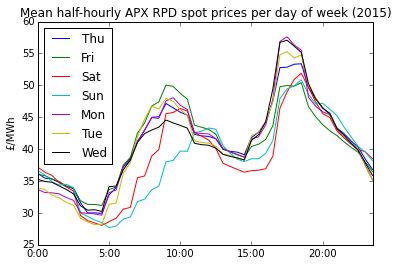

In [84]:
# Group by day of week and plot the mean half-hourly values across that day
dow = [dow_dict[x] for x in idx.dayofweek]
grp_dow = rpd_df.groupby(dow, sort=False).mean()
grp_dow.T.plot()
plt.ylabel('£/MWh')
plt.title('Mean half-hourly APX RPD spot prices per day of week (2015)')
plt.show()
del grp_dow

If we split the data up by the day of week, we can see a relatively tight spread for the weekdays, and a slightly different picture on the weekend.  Interestingly, on Saturday and Sunday the 09:30 maxima described above lags slightly, indicating a lie-in (which is more pronounced on Sunday).  The 18:00 maxima stays the same, but the average price decreases as the week goes on.  This could be an indicator of people leaving work later as the week goes on.

#### Heatmap of half-hourly spot prices for each day of week:

C:\Users\Gus\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


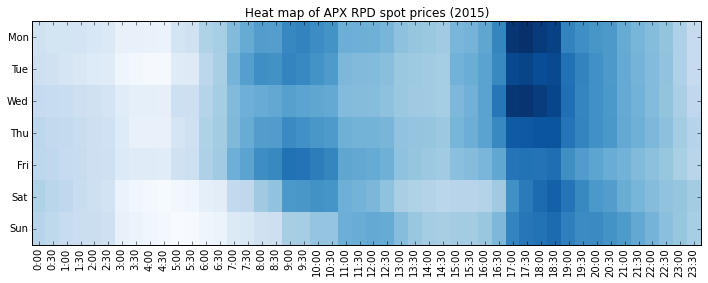

In [140]:
# Group by day of week and plot the mean half-hourly values across that day
dow = [dow_dict[x] for x in idx.dayofweek]
grp_dow = rpd_df.groupby(dow, sort=False).mean()
grp_dow = grp_dow.reindex(dow_dict.values())

# Plot the data
fig, ax = plt.subplots(figsize=(12,4))
heatmap = ax.pcolor(grp_dow, cmap=plt.cm.Blues)

# Y-axis
ax.set_yticks(np.arange(grp_dow.shape[0]) + 0.5, minor=False)
ax.set_yticklabels(grp_dow.index.values, minor=False)
ax.invert_yaxis()

# X-axis
ax.set_xticks(np.arange(grp_dow.shape[1]) + 0.5, minor=False)
ax.set_xticklabels(grp_dow.columns.values, minor=False)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.title('Heat map of APX RPD spot prices (2015)')
plt.axis('tight')
plt.show()
del grp_dow

By plotting the heatmap, we can clearly see the strong minima at 04:00, and a less strong one at 15:00.  The maxima at 09:30 is there, although it is weaker on Wednesday and stronger on Friday, and considerably lagged on Saturday and Sunday.  The maxima at 17:30 is also present, although it is much stronger on Monday and Wednesday.  It would be interesting to investigate why the spot prices are lower than average on Wednesday at 09:00, but higher than average at 18:00.

### Average Spot Prices
We can also run some additional analysis on the 2015 spot prices, to see what information can be gleaned when we average the prices over the year.

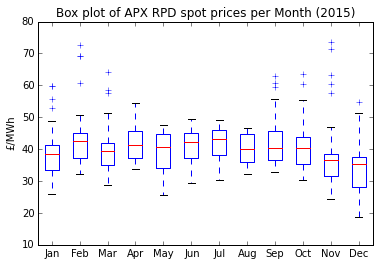

In [85]:
# Group by month and plot a box-plot of each months energy prices
month = [label_dict[x][0] for x in idx.month]
grp_month = rpd_df.groupby(month, sort=False).mean()
grp_month.T.plot(kind='box')
plt.ylabel('£/MWh')
plt.title('Box plot of APX RPD spot prices per Month (2015)')
plt.show()
del grp_month

Boxplots will allow us to see the variability in the spot prices.  We appear to get less variability in the summer months (June to August) than the rest of the year, this could be due to decreasing use of heating stabilising the system.

#### Incorporating Temperature
We can do some analysis to see how closely aligned the average UK temperature is to the spot prices.
I've downloaded a dataset from the [metoffice](http://www.metoffice.gov.uk/pub/data/weather/uk/climate/datasets/Tmean/ranked/UK.txt) and cleaned up the data below.

In [91]:
# Download UK average temperature data from the MET office
# Download to local file for easy access
if not os.path.isfile('./uk_temp.csv'):
    uk_temp_url = 'http://www.metoffice.gov.uk/pub/data/weather/\
                   uk/climate/datasets/Tmean/ranked/UK.txt'
    uk_temp = pd.read_csv(uk_temp_url,
                      sep='\s+',
                      skiprows=7)
    uk_temp.to_csv('uk_temp.csv', index=False)

uk_temp = pd.read_csv('./uk_temp.csv')

# Heavy data munging, the file was in the format of multiple data / year
# column combinations, all ordered by highest temp.  Needed to get it in
# the format of a single year column
data_cols = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN',
             'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC',
             'WIN', 'SPR', 'SUM', 'AUT', 'ANN']
year_cols = ['Year'] + ['Year.' + str(i) for i in range(1, 17)]
cols = zip(data_cols, year_cols)

# Sort each individual 'data' / 'year' combo and concat them together
uk_temp = pd.concat([uk_temp[[c1, c2]].sort_values(c2).reset_index() for c1, c2 in cols],
                    axis=1)

# Get rid of all the repeated 'Year' columns
uk_temp = uk_temp[['Year'] + data_cols]

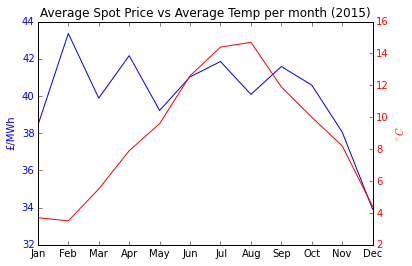

In [87]:
# Extract the average temperatures for 2015
temp2015 = uk_temp[uk_temp['Year'] == 2015].iloc[:, 1:13].T
temp2015['Year'] = [x.title() for x in list(temp2015.index.values)]
temp2015.set_index('Year', inplace=True)
del temp2015.index.name

# Group spot prices by month and plot the mean
month = [label_dict[x][0] for x in idx.month]
grp_month = rpd_df.groupby(month, sort=False).mean().mean(axis=1)

# Plot the data
fig, ax1 = plt.subplots()
ax1.plot(grp_month.values, color='blue')
ax1.set_xticks([x for x in range(0,13)])
ax1.set_xticklabels(temp2015.index.values)
ax1.set_ylabel("£/MWh", color="blue")
for label in ax1.get_yticklabels():
    label.set_color("blue")

ax2 = ax1.twinx()
ax2.plot(temp2015.values, color="red")
ax2.set_ylabel(r"$^{\circ}C$", color="red")
for label in ax2.get_yticklabels():
    label.set_color("red")

plt.title('Average Spot Price vs Average Temp per month (2015)')
plt.show()

del grp_month
del temp2015

It appears as though the average spot price between January and May is highly uncorrelated with the temperature, but between May and Dec it is more highly correlated.  Maybe the spot price is more sensitive to temperature changes in the summer (when heating systems are used more sparsely), worth investigating further.

#### Taking an annual look
Next I will take a look at the general trend over the year, and compare to previous years.

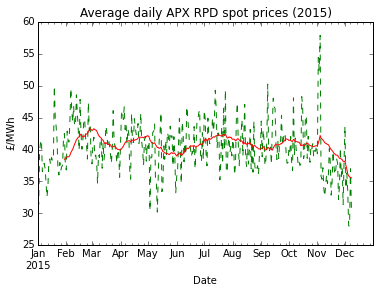

In [88]:
# Look at the average prices over the year, and fit a rolling mean
daily_ave = rpd_df.mean(axis=1)
daily_ave.plot(style='g--')
pd.rolling_mean(daily_ave, window=30).plot(style='-r')
plt.ylabel('£/MWh')
plt.title('Average daily APX RPD spot prices (2015)')
plt.show()
del daily_ave

At first glance it appears that there is no general trend over 2015.  I will now compare with the previous 5 years.

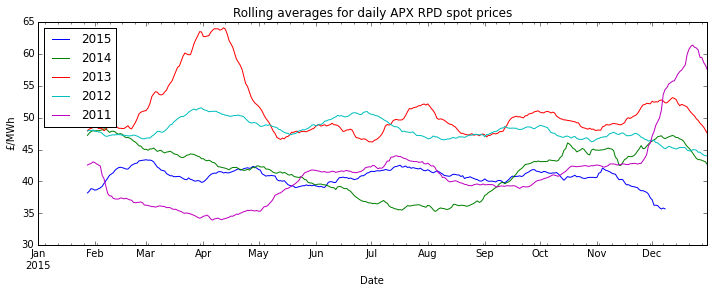

In [93]:
# Extract data for previous 5 years
rpd_df_14 = read_rpd_data('2014_rpd_rpd.csv')
rpd_df_13 = read_rpd_data('2013_rpd_rpd.csv')
# rpd_df_12 = read_rpd_data('2012_rpd_rpd.csv') - faulty data
rpd_df_11 = read_rpd_data('2011_rpd_rpd.csv')
rpd_df_10 = read_rpd_data('2010_rpd_rpd.csv')

# Extract the rolling means
rolling = pd.concat([pd.rolling_mean(rpd_df.mean(axis=1), window=28).\
                         reset_index(drop=True),
                     pd.rolling_mean(rpd_df_14.mean(axis=1), window=28).\
                         reset_index(drop=True),
                     pd.rolling_mean(rpd_df_13.mean(axis=1), window=28).\
                         reset_index(drop=True),
                     pd.rolling_mean(rpd_df_11.mean(axis=1), window=28).\
                         reset_index(drop=True),
                     pd.rolling_mean(rpd_df_10.mean(axis=1), window=28).\
                         reset_index(drop=True)],
                   axis=1)

rolling.columns = ['2015', '2014', '2013', '2012', '2011']
rolling['Date'] = rpd_df.index.values
rolling.set_index('Date', drop=True, inplace=True)

# Plot the data
rolling.plot(figsize=(12, 4))
plt.ylabel('£/MWh')
plt.title('Rolling averages for daily APX RPD spot prices')
plt.show()

Interesting to see how variable the spot price is over the years, shows that the variability must be due to external effects rather than just seasonal patterns.